# Assignment #1 Part 1 - Spring 2016
##### by Darragh Hanley (gtid :903172680)

For this assignment I would like to try to kill a few birds with the same stone - complete the omscs assignment 1 (and learning more about the models) as well as participate in the [Homesite Kaggle](https://www.kaggle.com/c/homesite-quote-conversion) competition. My profile with the final results is here [here](https://www.kaggle.com/darraghdog/results).  
The data set is rather large, so we will not get to use all observations and will focus on the train set only. The data (30000 observations) will be separated into two portions, one for training and one for validation. The data shows anonymised features of quotes made to Homesite customers and they wish to predict whether the quote was converted. Further details [here](https://www.kaggle.com/c/homesite-quote-conversion) in team DEHO.  
I will assume that this CoC linux boxes have the necessary packages installed (sklearn, matplotlib, etc.), and if not generally "pip install *package-name*" can be used.

## Table of Contents
1. [Loading Packages](## Load packages)
2. [Preprocessing Data](## Preprocessing Data)
3. [Loading Data](## Loading the Data)
4. [Decision Trees](## Decision Trees)
5. [k-Nearest Neighbors](## k-Nearest Neighbors)

## Load packages

In [1]:
import os
import pandas as pd
import numpy as np
import io
import requests
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from sklearn import preprocessing
from sklearn.metrics import log_loss, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from nolearn.lasagne import NeuralNet
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.updates import adagrad, nesterov_momentum
from lasagne.nonlinearities import softmax
from lasagne.objectives import binary_crossentropy, binary_accuracy
import theano

Couldn't import dot_parser, loading of dot files will not be possible.


/home/darragh/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Loading Data
I have stored the train file in dropbox. Due to the runtimes involved we will focus our analysis only on the first 50,000 rows. It is possible to pull directly from Kaggle site into an IPython notebook, however a user name and password is needed for that.
note we have approximately 300 predictor columns which would mean, given the curse of dimensionality, we need many more rows to be able to learn from these 300 columns. Nevertheless 30000 should suffice, even if we split train and test set with 15000 in each.

In [2]:
# First we download the file from dropbox
url = "https://www.dropbox.com/s/cycxpmy17h974tv/train.csv?dl=1"   # dl=1 is important
s=requests.get(url).content
train=pd.read_csv(io.StringIO(s.decode('utf-8')), nrows=30000)
# preview the data and look at the shape
train.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,...,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,...,18,22,-1,10,-1,11,-1,12,N,IL


There is a target variable which we are trying to predict. This is seen below where we see approximately 50K quotes were converted while 200K+ quotes were uncoverted. This is the QuoteConversion_Flag. Kaggle is actually looking for the probabilities of each class (0,1) - more specifically they want the probability of a row being 1 or having a converted quote. 

/home/darragh/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


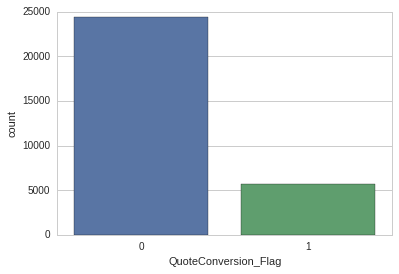

In [3]:
# Plot
sns.countplot(x="QuoteConversion_Flag", data=train)

## Metric  
AUC was the chose metric by Kaggle for this competition. I believe it is a good metric given the unbalaced classes seen above. It is used to judge predictions in binary response (0/1) problem. It is only sensitive to the order determined by the predictions and not their magnitudes.   

It is a commonly used evaluation method for binary choice problems, which involve classifying an instance as either positive or negative. Its main advantages over other evaluation methods, such as the simpler misclassification error, are:   

* It's insensitive to unbalanced datasets (datasets that have more installeds than not-installeds or vice versa).

* For other evaluation methods, a user has to choose a cut-off point above which the target variable is part of the positive class (e.g. a logistic regression model returns any real number between 0 and 1 - the modeler might decide that predictions greater than 0.5 mean a positive class prediction while a prediction of less than 0.5 mean a negative class prediction). AUC evaluates entries at all cut-off points, giving better insight into how well the classifier is able to separate the two classes.


## Preprocessing Data

We shall need to convert our date variable to a continuous variable which can be interpreted by the models. For this purpose we shall converts it into days weeks and months. We shall then drop the original date column as it cannot be interpreted as a continuous variable by the models.    

In [4]:
# target variable, and drop the index column
y = train.QuoteConversion_Flag.values
X = train.drop(['QuoteNumber', 'QuoteConversion_Flag'], axis=1)
# Now convert the date to day, month and week and drop the date
X['Date'] = pd.to_datetime(pd.Series(X['Original_Quote_Date']))
X = X.drop('Original_Quote_Date', axis=1)
X['Year'] = X['Date'].apply(lambda x: int(str(x)[:4]))
X['Month'] = X['Date'].apply(lambda x: int(str(x)[5:7]))
X['weekday'] = X['Date'].dt.dayofweek
X = X.drop('Date', axis=1)

There are also some text labels which are not supported by models such as neural networks, but are possible in tree models. for this we shall create a function to convert these columns at a later time. We shall also break out the target variable and the predictor variables.  

In [5]:
def encode_labels(df):
    for f in df.columns:
        if df[f].dtype=='object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df[f].values))
            df[f] = lbl.transform(list(df[f].values))
    return df
X.Field6.values[:20]

array(['B', 'F', 'F', 'J', 'E', 'E', 'J', 'B', 'J', 'F', 'B', 'B', 'J',
       'B', 'F', 'J', 'B', 'F', 'B', 'E'], dtype=object)

In [6]:
# Now we check to see these values encoded
encode_labels(X).Field6.values[:20]

array([1, 5, 5, 6, 4, 4, 6, 1, 6, 5, 1, 1, 6, 1, 5, 6, 1, 5, 1, 4])

Finally we need to check for NA values, and if any exist fill them in with a value as many of the models cannot handle NA values. 

In [7]:
# For this we get the total number of values minus the number of positions in the data frame
print("Number of NA values : {0}".format((X.shape[0] * X.shape[1]) - X.count().sum()))  
X = X.fillna(-1)

Number of NA values : 37366


The holdout method is the simplest kind of cross validation, and we shall employ it here. The data set is separated into two sets, called the training set and the testing set. The function approximator fits a function using the training set only. Then the function approximator is asked to predict the output values for the data in the testing set (it has never seen these output values before). The errors it makes are accumulated as before to give the mean absolute test set error, which is used to evaluate the model. 

In [8]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=0)

## Decision Trees

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.  
Instead of using pruining, like in class, we shall use max_depth of the tree and only grow the tree to a certain depth. This is more inefficient than pruning, as with pruning one large tree can be grown and test at different depths. This is as opposed to our method where we need to grow a new tree for each 
For interpreting the results in a visual we shall use a max depth of only three levels. We shall also use the node splitting criterion of entropy which was used in class.   
We can see that the trees had no problem using text variables, as the X dataset is not yet encoded.

In [9]:
from sklearn import tree
from IPython.display import Image
clf = tree.DecisionTreeClassifier(max_depth=3, criterion='entropy')
clf = clf.fit(X, y)

We now plot the tree and show the a few things at each node. We show the field used to split at each node and the splitting criteria. Example, in the first node, any rows with SalesField5 above 4.5 are put to one side where the entropy is quite a bit higher, as there are a more even proportion of classes.    
We show the entropy in each node, alongside the proportion of each class (Uncoverted Quotes (Yes) and Converted quotes (No)). We also show the majority class in each node.
What is quite interesting is the blue node, where after just three splits, we can predict with 99% accuracy, 6.6% of the total rows as being in the minority class of converted quotes.
The color of the nodes indicates how much that node leans to a particular class - the more blue is converted quotes, the more orange is more chance of unconverted quotes.   

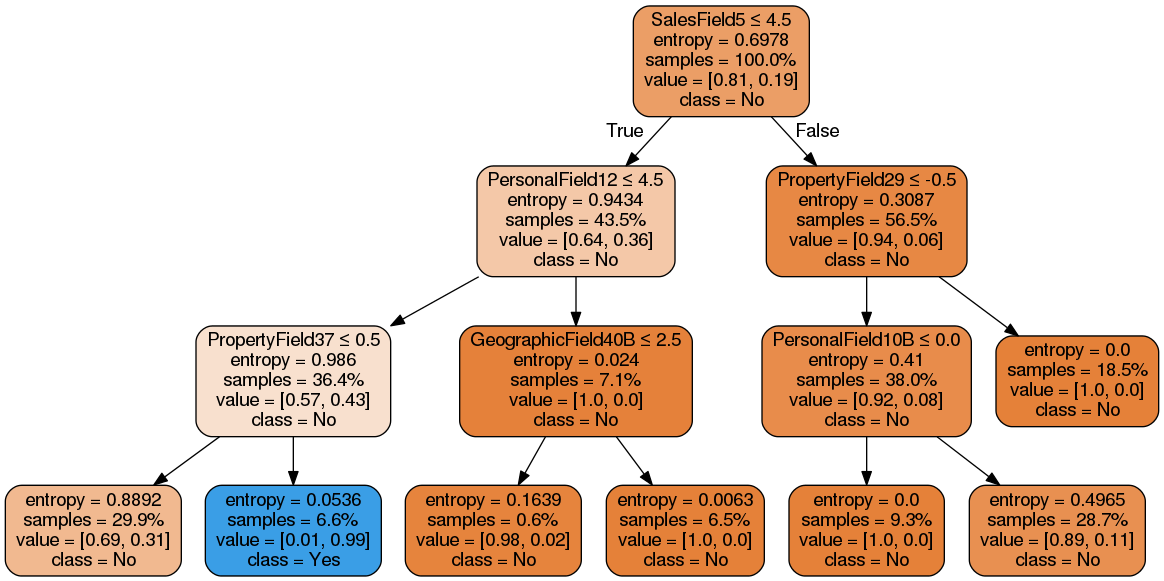

In [10]:
def plot_tree(clf,feature_names):
    tree.export_graphviz(clf,out_file='tree.dot',class_names=['No','Yes'],feature_names=feature_names, 
                         filled=True, rounded=True, special_characters=True, proportion=True)
    os.system("dot -Tpng tree.dot -o tree.png")
    os.system("tree.png")
plot_tree(clf, X.columns)
# Note : Uncoverted Quotes (Yes) and Converted quotes (No)
Image(filename='tree.png') 

In [11]:
depth = 15
tree_auc_trn, tree_auc_tst = np.zeros(depth), np.zeros(depth)
for i in range(1,depth):
    clf1 = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy')
    clf1 = clf1.fit(X_train, y_train)
    tree_auc_trn[i] = roc_auc_score(y_test, clf1.predict_proba(X_test)[:,1])
    tree_auc_tst[i] = roc_auc_score(y_train, clf1.predict_proba(X_train)[:,1])

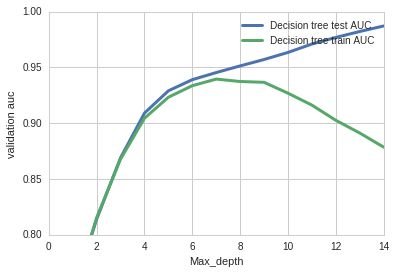

In [12]:
from matplotlib import pyplot
pyplot.plot(tree_auc_tst, linewidth=3, label = "Decision tree test AUC")
pyplot.plot(tree_auc_trn, linewidth=3, label = "Decision tree train AUC")
pyplot.legend()
pyplot.ylim(0.8, 1.0)
pyplot.xlabel("Max_depth")
pyplot.ylabel("validation auc")
plt.figure(figsize=(12,12))
pyplot.show()

print "Best Test Score", max(tree_auc_tst)

We can see from the above diagram the optimal depth. Any deeper and the test error rate increases while the training error continues to increase in what we call overfitting to the data.  
  
We shall now try to beat this score with boosting the trees.  

## Boosting

#### Gradient boosting takes the error of each tree and fixes the error with the next tree, instead of adaboosting
#### Compare this to the tree to see how a combination of simple trees works so well.

Now we wish to boost our decision trees. Although the class mainly focused on Adaboost, we will choose another popular form of boosting callend Gradient Boosting. This was been found to perform more strongly than Adaboost on most recent Kaggle competitions where I competed.  
Gradient boosting produces a prediction model in the form of an ensemble of weak prediction models, in this case decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.  
The number of weak learners (i.e. decision trees) is controlled by the number of estimators; The size of each tree can be controlled either by max_depth as before. The learning_rate is a hyper-parameter in the range (0.0, 1.0] that controls overfitting via shrinkage which gradually reduces the impact ob predictions of each subsequent tree generated. however increased shrinkage lead to longer run times.  

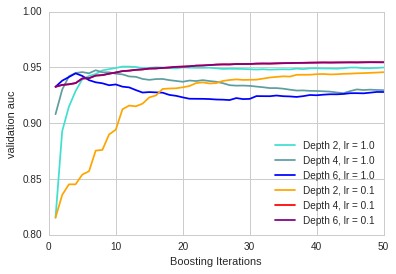

In [13]:
#We shall start by looking at different hyperparameters
from sklearn.ensemble import GradientBoostingClassifier as gbm
original_params = {'n_estimators': 50, 'random_state': 2}

plt.figure()
for label, color, setting in [('Depth 2, lr = 1.0', 'turquoise', {'learning_rate': 1.0, 'max_depth': 2}),
                              ('Depth 4, lr = 1.0', 'cadetblue',      {'learning_rate': 1.0, 'max_depth': 4}),
                              ('Depth 6, lr = 1.0', 'blue',      {'learning_rate': 1.0, 'max_depth': 6}),
                              ('Depth 2, lr = 0.1', 'orange',    {'learning_rate': 0.1, 'max_depth': 2}),
                              ('Depth 4, lr = 0.1', 'red',    {'learning_rate': 0.1, 'max_depth': 6}),
                              ('Depth 6, lr = 0.1', 'purple',      {'learning_rate': 0.1, 'max_depth': 6})]:
    params = dict(original_params)
    params.update(setting)
    clf = gbm(**params)
    clf.fit(X_train, y_train)

    # compute test set auc
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_predict_proba(X_test)):
        test_deviance[i] = roc_auc_score(y_test, y_pred[:,1])
    #print test auc
    plt.plot((np.arange(test_deviance.shape[0]) + 1), test_deviance,
            '-', color=color, label=label)

plt.legend(loc='lower right')
pyplot.ylim(0.8, 1.0)
plt.xlabel('Boosting Iterations')
pyplot.ylabel("validation auc")
plt.figure(figsize=(12,12))
plt.show()

## k-Nearest Neighbors

As opposed to decision tree models and most other models, KNN is a form instance based learning, which uses the training instances, instead of a learned function, to classify the test instances. For this reason, the learning part of the function is fast (it only save the data), while the predict part of the algorithm needs to find the neighbors and takes longer. Specific to our kaggle Homesite data, we have many rows, so we need to choose relatively large numbers of K.

k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. 
We shall again use the scikit learn library to predict based on KNN. 
Below we test measure the train and test error on increasing values of k. As the data set is large, we are better off with large values of k. 
We use a few extra parameters in the model. The weights is set to uniform meaning each of the neighbors are treated equally ie. for k=50, we treat the nearest neighbor with equal imporance to the 50th nearest neigbor. An alternative would be to give the further away instances a lower weighting.
The metric used is minkowski, and with p=2, it is equivalent to the standard Euclidean metric.   

A very important consideration in using distance metrics is to scale our inputs. As our data in anonymised we have little reason to have one column on a larger scale (giving it more weight) than another column.  In a tree based model the scales of a variable are not important however for KNN when measuring the nearest neighbors the variables should be scaled equally unless we have specific reason to weight a variable higher, otherwise a variable with a large variance would dwarf a variable with a lower variance.  
An example can be seen below with our first few variables where Field 7 would dwarf the other four vairables due to it' much larger standard deviation.

In [14]:
X.ix[:,:5].describe().ix[[1,2,3,7]]

,Field6,Field7,Field8,Field9,Field10
mean,3.676933,18.305133,0.938131,0.001445,3.922033
std,2.188528,7.400296,0.037009,0.001482,2.474731
min,0.000000,1.000000,0.874600,0.000400,0.000000
max,7.000000,28.000000,1.010100,0.004000,7.000000


Now we shall scale our variables using sklearn and also convert the categorical variables to numerical variables.   
We then import a standard scaler from scikit learn and scale our variables to the same dimensions.   
We then recreate our train and set set. As we use the same random seed, the same train and test split will be made over the rows as before, however this time the train and test data will be scaled.
We can use this scaled and encoded data for later models. 

In [15]:
X = encode_labels(X) # encode our variables
cols = X.columns

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=0)

Lets look at our scale data before modelling. 

In [17]:
pd.DataFrame(X, columns=cols).ix[:,:5].describe().ix[[1,2,3,7]]

,Field6,Field7,Field8,Field9,Field10
mean,-2.185067e-16,-4.971579e-17,2.552403e-16,-1.089425e-16,-1.706986e-16
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.680122e+00,-2.338477e+00,-1.716652e+00,-7.047116e-01,-1.584859e+00
max,1.518428e+00,1.310086e+00,1.944646e+00,1.723886e+00,1.243779e+00


We now see all the columns are scaled to the same standard deviation of 1 and the same mean of approximately 0. 

For our instance based algorithm, kNN, we choose larger values of k, because the number of observations of large. We ttry from 10 to 70 in increments of 10. We will put equal weights on each of the nearest neighbours -  All points in each neighborhood are weighted equally. As in other algorithms, to use the AUC metric, we shall predict the probability of an instance being a 1, or a converted quote. Our distance meteric is minkowski, and with p=2 is equivalent to the standard Euclidean metric.  

In [18]:
from sklearn.neighbors import KNeighborsClassifier
kn = range(5,35,5)
kauc_trn, kauc_tst = np.zeros(len(kn)), np.zeros(len(kn))
for i, k in zip(range(0, len(kn)), kn):
    clf1 = KNeighborsClassifier(n_neighbors=k, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, p=2, weights='uniform')
    clf1 = clf1.fit(X_train, y_train)
    pred_tst = clf1.predict_proba(X_test)[:,1]
    pred_trn = clf1.predict_proba(X_train)[:,1]
    kauc_tst[i] = roc_auc_score(y_test, pred_tst)
    kauc_trn[i] = roc_auc_score(y_train, pred_trn)

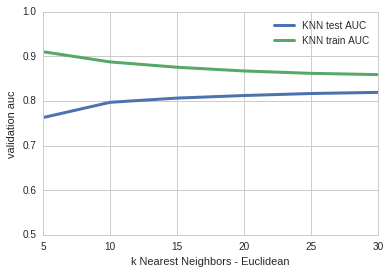

In [19]:
pyplot.plot(kn, kauc_tst, linewidth=3, label = "KNN test AUC")
pyplot.plot(kn, kauc_trn, linewidth=3, label = "KNN train AUC")
#pyplot.grid()
pyplot.legend()
pyplot.ylim(0.5, 1.0)
pyplot.xlabel("k Nearest Neighbors - Euclidean")
pyplot.ylabel("validation auc")
plt.figure(figsize=(12,12))
pyplot.show()

We can see from the above result that the k-nearest neighbor algorithm does not perform as strongly as the decision tree. The best test error is found at around 30 neighbours and from there it seems to taper with a steady performance.   
Note the very accurate training error on low values of k. This is because the one of the nighbors is the actual value we try to predict.   

In [20]:
print "Best test set auc is %0.3f" % kauc_tst.max(), "for %0.0f neighbors" % list(range(10,71,10))[kauc_tst.argmax()]

Best test set auc is 0.819 for 60 neighbors


In order to check if changing the distance metric we shall now check the same parameters using manhatten distance. Ideally we should also run this for each value of k however we will only run it for the best euclidean k due to time restrictions.

In [21]:
clf2 = KNeighborsClassifier(n_neighbors=50, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, p=1, weights='uniform') # p=1 for manhatten
clf2.fit(X_train, y_train)
best_manh = clf2.predict_proba(X_test)[:,1]

In [22]:
print "Test set auc using manhatten distance is %0.3f" % roc_auc_score(y_test, best_manh), "for %0.0f neighbors" % list(range(10,71,10))[kauc_tst.argmax()]

Test set auc using manhatten distance is 0.824 for 60 neighbors


So for this particular number of neighbors manhatten did not perform better than euclidean distance.

## Neural Networks

Lasagne is a lightweight library we shall us to build and train neural networks in Theano for our dataset. 
For neural networks we do need our columns scaled to the same dimension in order to treat all column equally (or at least, not having any reason not to). We also need encoded labels.  
We have to input a number of paramters to the Neural Network,
* Number of classes - this will be taken from the response where we have two classes
* Number of feautures we are passing into the network
* The number of feedback loops for back propagation, in our case these are called epochs. We shall use 10. 
We initalise our network with a dense layer, meaninig afully connected layer (all nodes are connected). We add 512 nodes to this layer however to avoid overfitting we introduce a dropout layer which shall only activate some of the connections between layers on each epoch or feedback loop. The weight matrix W of this dense layer will be initialized using samples from a normal distribution with standard deviation 0.01.   
   
Our loss function which the network optimises upon is called binary cross entropy. We shall not use a sigmoid activation function, but instead use softmax which is faster and suit to a problem where each single response value is in [0, 1].

AdaGrad is an Adaptive Gradient Method that implies different adaptive learning rates for each feature, is used as a substitution for momentum to ensure we reduce the chance of getting stuck in local mimima. We also specify the learning rate of 0.4, which could be tuned for better results.  
   
In a second round we introduce a second layer and check the performance when a layer of 256 nodes is intorduced on top of the first layer. 

In [23]:
# Now we prep the data for a neural net
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train).astype(np.int32)
y_test = encoder.fit_transform(y_test).astype(np.int32)
num_classes = len(encoder.classes_)
num_features = X_train.shape[1]
epochs = 20
val_auc1A, val_auc2A = np.zeros(epochs), np.zeros(epochs)
val_auc1B, val_auc2B = np.zeros(epochs), np.zeros(epochs)
# Comment out second layer for run time.
layers = [('input', InputLayer),
           ('dense0', DenseLayer),
           ('dropout0', DropoutLayer),
           #('dense1', DenseLayer)
           #('dropout1', DropoutLayer),
           ('output', DenseLayer)
           ]
net1 = NeuralNet(layers=layers,
                 input_shape=(None, num_features),
                 dense0_num_units=512, 
                 dropout0_p=0.1,
                 # dense1_num_units=256,
                 # dropout1_p=0.1,
                 output_num_units=num_classes,
                 output_nonlinearity=softmax,
                 update=adagrad,
                 update_learning_rate=0.04,
                 eval_size=0.0,
                 verbose=0,
                 max_epochs=1)
for i in range(epochs):
    net1.fit(X_train, y_train)
    pred = net1.predict_proba(X_test)[:,1]
    val_auc1A[i] = roc_auc_score(y_test,pred)
    pred = net1.predict_proba(X_train)[:,1]
    val_auc1B[i] = roc_auc_score(y_train,pred)
    

/home/darragh/anaconda2/lib/python2.7/site-packages/nolearn/lasagne/base.py:206: UserWarning: The 'eval_size' argument has been deprecated, please use the 'train_split' parameter instead, e.g.
train_split=TrainSplit(eval_size=0.4)
  warn("The 'eval_size' argument has been deprecated, please use "
/home/darragh/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [24]:
# Add a second layer to the network. 
layers = [('input', InputLayer),
           ('dense0', DenseLayer),
           ('dropout0', DropoutLayer),
           ('dense1', DenseLayer),
           ('dropout1', DropoutLayer),
           ('output', DenseLayer)
           ]
net2 = NeuralNet(layers=layers,
                 input_shape=(None, num_features),
                 dense0_num_units=512, 
                 dropout0_p=0.1,
                 dense1_num_units=256,
                 dropout1_p=0.1,
                 output_num_units=num_classes,
                 output_nonlinearity=softmax,
                 update=adagrad,
                 update_learning_rate=0.04,
                 eval_size=0.0,
                 verbose=0,
                 max_epochs=1)
for i in range(epochs):
    net2.fit(X_train, y_train)
    pred = net2.predict_proba(X_test)[:,1]
    val_auc2A[i] = roc_auc_score(y_test,pred)
    pred = net2.predict_proba(X_train)[:,1]
    val_auc2B[i] = roc_auc_score(y_train,pred)

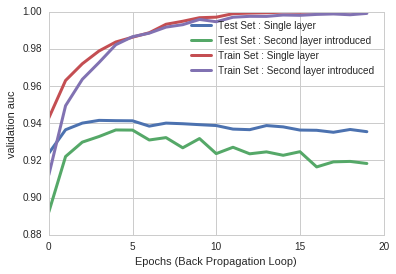

In [25]:
from matplotlib import pyplot
pyplot.plot(val_auc1A, linewidth=3, label="Test Set : Single layer")
pyplot.plot(val_auc2A, linewidth=3, label="Test Set : Second layer introduced")
pyplot.plot(val_auc1B, linewidth=3, label="Train Set : Single layer")
pyplot.plot(val_auc2B, linewidth=3, label="Train Set : Second layer introduced")
#pyplot.grid()
plt.legend(loc='upper right')
pyplot.xlabel("Epochs (Back Propagation Loop)")
pyplot.ylabel("validation auc")
pyplot.show()

It is to be noted that both models converge very quickly. One can also see that the double layer network tends to overfit more, perhaps as it has more flexibility. 

## Support Vector Machine

In [26]:
# Now we prep the data for a neural net
from sklearn import svm
costs = np.power(10.0, range(-2,2))
kernels = ['linear', 'poly', 'rbf']
auc_rad_tst = np.zeros((len(costs),len(kernels)))
auc_rad_trn = np.zeros((len(costs),len(kernels)))
# Comment out second layer for run time.
for i in range(len(costs)):
    for k in range(len(kernels)):
        print i, k
        svc = svm.SVC(kernel = kernels[k], C=costs[i], probability=True)
        svc.fit(X_train,y_train)
        auc_rad_tst[i,k] = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])
        auc_rad_trn[i,k] = roc_auc_score(y_train, svc.predict_proba(X_train)[:,1])

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2


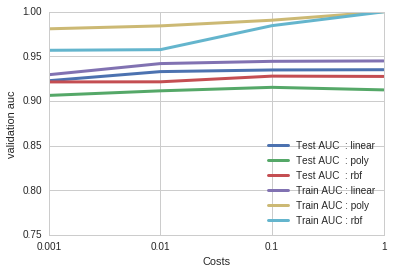

In [28]:
for k in range(len(kernels)):
    pyplot.plot(auc_rad_tst[:,k], linewidth=3, label="Test AUC  : "+kernels[k])
for k in range(len(kernels)):
    pyplot.plot(auc_rad_trn[:,k], linewidth=3, label="Train AUC : "+kernels[k])
#pyplot.grid()
plt.legend(loc='lower right')
pyplot.ylim(0.75, 1.0)
np.set_printoptions(precision=3)
plt.xticks(range(len(costs)),['0.001', '0.01','0.1', '1','10', '100','1000'])
pyplot.xlabel("Costs")
pyplot.ylabel("validation auc")
pyplot.show()